# AACR slides: Violin plot for the CTC cohort

### Mount data directory

In [1]:
!gcsfuse --implicit-dirs scrnaseq_benchmarking ~/data/

2022/03/17 12:45:11.591143 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /home/jtsuji/data
2022/03/17 12:45:11.611089 Opening GCS connection...
2022/03/17 12:45:11.836995 Mounting file system "scrnaseq_benchmarking"...
2022/03/17 12:45:11.848939 File system has been successfully mounted.


### Load libraries

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

### Load AnnData

In [3]:
# (69.12 GiB) gs://scrnaseq_benchmarking/aacr/mal_cells_for_junko_adata.h5ad
adata = sc.read_h5ad("/home/jtsuji/data/aacr/mal_cells_for_junko_adata.h5ad")

adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,scrublet_score,doublet,sample_id,bcr_raw_clonotype_id,bcr_clono_co,batch,plas_call
barcode,,,,,,,,,,,,,,,,
GACAGAGAGTGACTCT-1-0-0,2.680493,0.999986,6747.285156,TPC,3443,32340.0,214.0,0.661719,3443,0.058954,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
CATCGAATCATTGCGA-1-0-0,2.592071,0.999983,6423.836426,TPC,3061,31452.0,162.0,0.515071,3061,0.040225,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
AGCAGCCAGGACAGAA-1-0-0,2.554361,0.999979,6736.926758,TPC,3295,29711.0,223.0,0.750564,3295,0.130590,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
GCGACCATCCGAAGAG-1-0-0,2.505002,0.999977,7024.260742,TPC,3232,29400.0,267.0,0.908163,3232,0.117207,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
TTCTCAATCTAGCACA-1-0-0,2.694450,0.999979,7314.036133,TPC,3737,29220.0,355.0,1.214921,3737,0.219448,True,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTATTCTCAAGCCTA-1-8-10,0.559692,0.999015,7608.150879,LQTPC,569,827.0,58.0,7.013301,569,0.051087,True,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum
AGATTGCGTAAGTAGT-1-8-10,0.653077,0.999217,7586.197754,LQTPC,452,736.0,135.0,18.342390,452,0.007548,False,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum
GACTAACCACGCTTTC-1-8-10,0.757090,0.998454,7705.398926,LQTPC,566,770.0,45.0,5.844156,566,0.145455,True,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum


### Combine metadata with AnnData

In [41]:
import copy

# load metadata
meta = pd.read_csv("/home/jtsuji/mm-single-cell-analysis-2022/notebooks/violin_metadata.csv", dtype=str)
meta['patient_id'] = meta["PAIR_NUMBER"]+"_"+meta["DISEASE_STAGE"]

# define new column names to link with AnnData ('patient_id' is new)
#          old column               new column
cols  = { "patient_id"           : "patient_id",
          "REDCAP_ID"            : "redcap_id",
          "tissue_type"          : "tissue_type",
          "IMMUNOFIX_LIGHT_CHAIN": "ifx",
          "DISEASE_STAGE"        : "disease",
          "20_2_20_RISK_STATUS"  : "risk",
          "CG"                   : "group" }

# create sample ID based dictionary from metadata
meta_dict = dict()
for i, row in meta.iterrows():
    row_i = dict(row[[c for c in cols.keys() if c != "tissue_type"]])
    for bm_id in row["BM_CATISSUE_SAMPLE_ID"].split("/"):
        sid = bm_id + "_BM"
        meta_dict.setdefault(sid, copy.deepcopy(row_i))
        meta_dict[sid]["tissue_type"] = "BM"
    for ctc_id in row["CTC_CATISSUE_SAMPLE_ID"].split("/"):
        sid = ctc_id + "_CTC"
        meta_dict.setdefault(sid, copy.deepcopy(row_i))
        meta_dict[sid]["tissue_type"] = "CTC"

# initialize new columns with NaN
for meta_col, new_col in cols.items():
    adata.obs[new_col] = pd.Series(np.full(adata.n_obs, np.nan), dtype=str)

# iterate and insert data
# this adata object is index by cell barcode (e.g. 'GACAGAGAGTGACTCT-1-0-0')
for cb, row in adata.obs.iterrows():
    s = adata.obs.loc[cb, "sample_id"].split("_")
    sid, sty = s[0], s[2]
    if sty == "BM":
        sid += "_BM"
    elif sty == "PB":
        sid += "_CTC"
    else:
        raise Exception("unknown type: {}".format(sty))
    for meta_col in map(str, meta_dict[sid].keys()):
        adata.obs.at[cb, cols[meta_col]] = meta_dict[sid][meta_col]
 
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,scrublet_score,...,bcr_clono_co,batch,plas_call,patient_id,redcap_id,tissue_type,ifx,disease,risk,group
barcode,,,,,,,,,,,,,,,,,,,,,
GACAGAGAGTGACTCT-1-0-0,2.680493,0.999986,6747.285156,TPC,3443,32340.0,214.0,0.661719,3443,0.058954,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
CATCGAATCATTGCGA-1-0-0,2.592071,0.999983,6423.836426,TPC,3061,31452.0,162.0,0.515071,3061,0.040225,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
AGCAGCCAGGACAGAA-1-0-0,2.554361,0.999979,6736.926758,TPC,3295,29711.0,223.0,0.750564,3295,0.130590,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
GCGACCATCCGAAGAG-1-0-0,2.505002,0.999977,7024.260742,TPC,3232,29400.0,267.0,0.908163,3232,0.117207,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
TTCTCAATCTAGCACA-1-0-0,2.694450,0.999979,7314.036133,TPC,3737,29220.0,355.0,1.214921,3737,0.219448,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTATTCTCAAGCCTA-1-8-10,0.559692,0.999015,7608.150879,LQTPC,569,827.0,58.0,7.013301,569,0.051087,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)
AGATTGCGTAAGTAGT-1-8-10,0.653077,0.999217,7586.197754,LQTPC,452,736.0,135.0,18.342390,452,0.007548,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)
GACTAACCACGCTTTC-1-8-10,0.757090,0.998454,7705.398926,LQTPC,566,770.0,45.0,5.844156,566,0.145455,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)


### Violin plot

In [53]:
import matplotlib.pylab as plt
import seaborn as sns

plt.rcParams["pdf.fonttype"] = 42
sns.set_style("white")
    
def stacked_split_violin(df, genes, x="patient_id", hue="tissue_type", order=None, linewidth=0.08):
    palette = {"BM": "red", "CTC": "blue"}
    fig, axes = plt.subplots(nrows=len(genes),
                             ncols=1,
                             figsize=(14, len(genes)),
                             sharex=True,
                             gridspec_kw=dict(hspace=0))
    for i,g in enumerate(genes):
        ax = sns.violinplot(data=df,
                            x=x,
                            y=g,
                            hue=hue,
                            inner=None,
                            linewidth=linewidth,
                            split=True,
                            order=order,
                            palette=palette,
                            ax=axes[i])
        ax.set_ylabel(g, rotation=0, ha="right")
        ax.set_yticklabels([])
        # legend setting
        if i == 0:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        else:
            ax.legend([], [], frameon=False)
        if i == len(genes)-1 and order != None:
            ax.set_xticklabels(order, rotation=90)

### Filter: removing pairs with no data and pairs whose CTC sample has < 5 cells

In [54]:
def filter_sample_by_cell_counts(d, sample_order):
    samples_to_keep = []
    for sid in sample_order:
        counts = d.obs[d.obs.patient_id == sid].tissue_type.value_counts()
        if len(counts) == 0:
            print("filtered: {} has no data points".format(sid))
        elif len(counts) < 2:
            print("filtered: {} only has {}".format(
                sid, ", ".join(counts.keys())))
        elif counts["BM"] < 5 or counts["CTC"] < 5:
            print("filtered: {} has cells < 5 (BM={} | CTC={})".format(
                sid, counts["BM"], counts["CTC"]))
        else:
            samples_to_keep.append(sid)
    return samples_to_keep

### Fig1B: GEX vs FISH

======== clinical grouping ========
  - t(11;14): 10_SMM, 16_SMM, 24_NDMM, 29_NDMM, 30_SMM, 32_MGUS, 36_NDMM, 41_SMM, 31_SMM
  - t(4;14): 2_SMM, 5_SMM, 23_SMM
  - t(14;16): 6_SMM, 17_SMM, 44_NDMM
  - HRD: 3_SMM, 13_SMM, 28_SMM, 40_SMM, 7_SMM, 20.1_SMM, 20.2_SMM
  - NonSpecific_IgH_Abnormality: 19_SMM, 22_SMM, 4_SMM, 25_SMM, 42_MGUS
  - Normal: 8_SMM, 9_SMM, 11_SMM, 12_SMM, 14_SMM, 15_SMM, 21_MGUS, 27_SMM, 33_SMM, 34_SMM, 38_SMM, 39_SMM
  - FISH_Failure: 1_SMM, 18_SMM, 26_SMM, 35_MGUS, 37_MGUS, 43_MGUS

filtered: 31_SMM has cells < 5 (BM=11624 | CTC=2)
filtered: 20.2_SMM has no data points
filtered: 21_MGUS has no data points
filtered: 27_SMM has cells < 5 (BM=4157 | CTC=3)
filtered: 38_SMM only has BM
filtered: 18_SMM only has BM
filtered: 35_MGUS only has BM


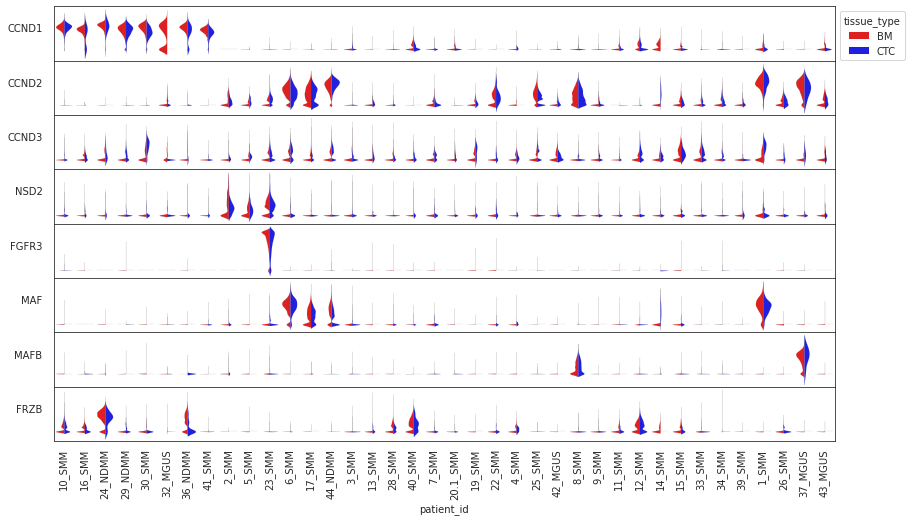

In [55]:
from collections import OrderedDict

# plotting group order
group_order = ["t(11;14)", "t(4;14)", "t(14;16)", "HRD", "NonSpecific_IgH_Abnormality", "Normal", "FISH_Failure"]

# group labels
#                             plotting label                 CG groups in the metadata
group_labels = OrderedDict( { "t(11;14)"                   : ["t(11;14)", "HRD_t(11;14)"],
                              "t(4;14)"                    : ["t(4;14)"],
                              "t(14;16)"                   : ["t(14;16)"],
                              "HRD"                        : ["HRD", "HRD_Del14q"],
                              "NonSpecific_IgH_Abnormality": ["Del14q", "t(x;14)"],
                              "Normal"                     : ["Normal"],
                              "FISH_Failure"               : ["Fail"] } )

# get ordered samples with the clinical grouping
print("======== clinical grouping ========")
sample_order = []
for g in group_labels.keys():
    s = []
    for cg in group_labels[g]:
        s.extend(list(meta[meta["CG"] == cg]["patient_id"]))
    sample_order.extend(s)
    # print group labels and the samples
    print("  - {}: {}".format(g, ", ".join(s)))
print("===================================\n")

# filter any samples with no data or with < 5 cells
sample_order = filter_sample_by_cell_counts(adata, sample_order)

# marker gene order
marker_genes = ["CCND1", "CCND2", "CCND3", "NSD2", "FGFR3", "MAF", "MAFB", "FRZB"]

# plot figure 1B
df = sc.get.obs_df(adata, ["patient_id", "tissue_type"]+marker_genes).reset_index()

stacked_split_violin(df,
                     marker_genes,
                     x="patient_id",
                     hue="tissue_type",
                     order=sample_order,
                     linewidth=0.08)
plt.savefig("/home/jtsuji/mm-single-cell-analysis-2022/figures/ctc_paper/fig1b.pdf")

### Fig1C: GEX vs IFX concordance

First plot all the Ig genes:

======== immunofix grouping ========
  - IgG_Kappa: 1_SMM, 3_SMM, 7_SMM, 12_SMM, 16_SMM, 20.1_SMM, 20.2_SMM, 21_MGUS, 23_SMM, 28_SMM, 31_SMM, 32_MGUS, 35_MGUS, 36_NDMM, 37_MGUS, 39_SMM, 40_SMM, 43_MGUS, 14_SMM
  - IgG_Lambda: 2_SMM, 4_SMM, 8_SMM, 17_SMM, 18_SMM, 19_SMM, 27_SMM, 33_SMM, 34_SMM, 41_SMM, 42_MGUS, 26_SMM, 13_SMM, 30_SMM
  - IgA_Kappa: 11_SMM, 15_SMM, 22_SMM, 29_NDMM, 38_SMM
  - IgA_Lambda: 5_SMM, 24_NDMM, 44_NDMM
  - Light_Chain_Only_Kappa: 6_SMM
  - Light_Chain_Only_Lambda: 9_SMM, 10_SMM, 25_SMM

filtered: 20.2_SMM has no data points
filtered: 21_MGUS has no data points
filtered: 31_SMM has cells < 5 (BM=11624 | CTC=2)
filtered: 35_MGUS only has BM
filtered: 18_SMM only has BM
filtered: 27_SMM has cells < 5 (BM=4157 | CTC=3)
filtered: 38_SMM only has BM


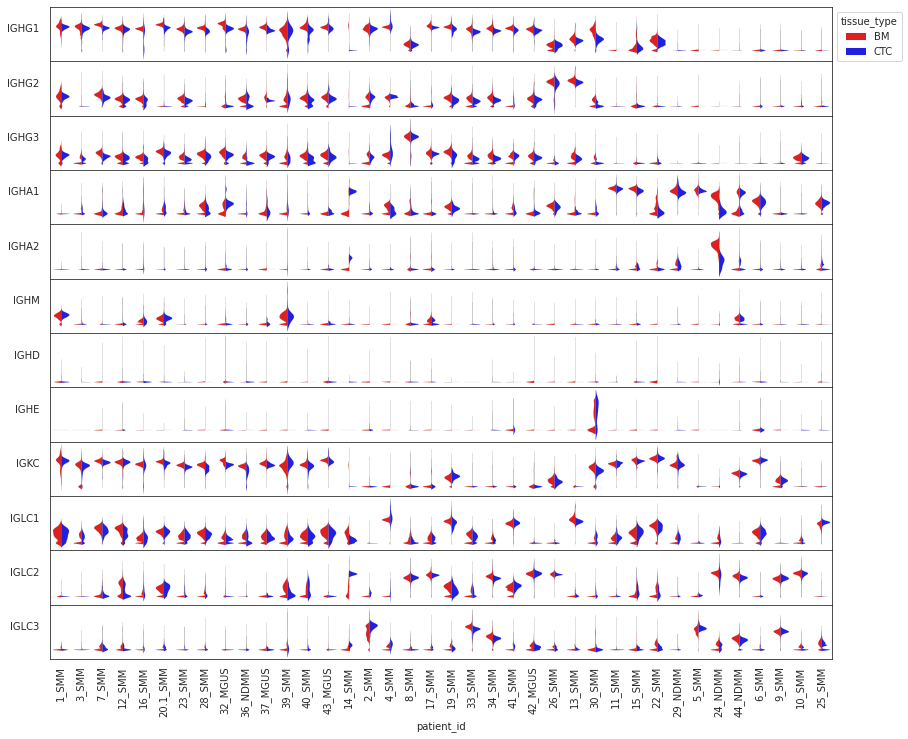

In [61]:
# plotting group order
group_order = ["IgG_Kappa", "IgG_Lambda", "IgA_Kappa", "IgA_Lambda",
               "Light_Chain_Only_Kappa", "Light_Chain_Only_Lambda"]

# group labels
#                             plotting label            IMMUNOFIX_LIGHT_CHAIN in the metadata
group_labels = OrderedDict( { "IgG_Kappa"              : ["IgG_Kappa", "IgG_Kappa.Heavy_Chain_Only_IgA"],
                              "IgG_Lambda"             : ["IgG_Lambda", "IgG_Lambda.IgM_Kappa",
                                                          "IgG_Lambda.Heavy_Chain_Only_IgA", "IgG_Lambda.IgG_Kappa.Heavy_Chain_Only_IgA"],
                              "IgA_Kappa"              : ["IgA_Kappa"],
                              "IgA_Lambda"             : ["IgA_Lambda", "IgA_Lambda.Light_Chain_Only_Lambda"],
                              "Light_Chain_Only_Kappa" : ["Light_Chain_Only_Kappa"],
                              "Light_Chain_Only_Lambda": ["Light_Chain_Only_Lambda"] } )

# get ordered samples with the IFX grouping
print("======== immunofix grouping ========")
sample_order = []
for g in group_labels.keys():
    s = []
    for ifx in group_labels[g]:
        s.extend(list(meta[meta["IMMUNOFIX_LIGHT_CHAIN"] == ifx]["patient_id"]))
    sample_order.extend(s)
    # print group labels and the samples
    print("  - {}: {}".format(g, ", ".join(s)))
print("====================================\n")

# filter any samples with no data or with < 5 cells
sample_order = filter_sample_by_cell_counts(adata, sample_order)


# marker gene order
marker_genes = ["IGHG1", "IGHG2", "IGHG3", "IGHA1", "IGHA2",
                "IGHM", "IGHD", "IGHE", "IGKC", "IGLC1", "IGLC2", "IGLC3"]

df = sc.get.obs_df(adata, ["patient_id", "tissue_type"]+marker_genes).reset_index()
stacked_split_violin(df,
                     marker_genes,
                     x="patient_id",
                     hue="tissue_type",
                     order=sample_order,
                     linewidth=0.08)

plt.savefig("/home/jtsuji/mm-single-cell-analysis-2022/figures/ctc_paper/fig1c.pdf")

Then plot grouped Ig genes:

In [149]:
# marker gene order
marker_genes = ["IGHG1", "IGHG2", "IGHG3", "IGHA1", "IGHA2",
                "IGHM", "IGHD", "IGHE", "IGKC", "IGLC1", "IGLC2", "IGLC3"]

# marker gene grouping
marker_gene_group = OrderedDict( { "IGHG": ["IGHG1", "IGHG2", "IGHG3"],
                                   "IGHA": ["IGHA1", "IGHA2"],
                                   "IGHM": ["IGHM"],
                                   "IGHD": ["IGHD"],
                                   "IGHE": ["IGHE"],
                                   "IGKC": ["IGKC"],
                                   "IGLC": ["IGLC1", "IGLC2", "IGLC3"] } )

df = sc.get.obs_df(adata, ["patient_id", "tissue_type"]+marker_genes).reset_index()
np.expm1(df[marker_gene_group["IGHG"]])

## we won't do it for now to figure out a potentially contaminated sample ('30_SMM') with IGHE expression

,IGHG1,IGHG2,IGHG3
0,3.206870,-0.404413,0.279971
1,3.658510,-0.404413,0.116475
2,3.500659,-0.404413,0.733091
3,4.452116,-0.404413,0.548357
4,4.149323,-0.404413,0.356337
...,...,...,...
420811,-0.557589,-0.404413,-0.432470
420812,-0.557589,-0.404413,-0.432470
420813,-0.557589,-0.404413,-0.432470
420814,-0.557589,-0.404413,-0.432470


In [150]:
# metadata of problematic sample
meta[meta.patient_id == "30_SMM"]

,PAIR_NUMBER,REDCAP_ID,BM_CATISSUE_SAMPLE_ID,CTC_CATISSUE_SAMPLE_ID,IMMUNOFIX_LIGHT_CHAIN,DISEASE_STAGE,20_2_20_RISK_STATUS,CG,patient_id
30,30,PANGEA_4439,pM10977,pM1363,IgG_Lambda.IgG_Kappa.Heavy_Chain_Only_IgA,SMM,LRSMM,t(11;14),30_SMM


In [151]:
# Danielle's manual labels for tumor cells
adata.obs[adata.obs.patient_id == "30_SMM"].cell_type.value_counts()

TPC1     5314
TPC2      654
LQTPC     409
TPC        83
LCTPC       0
Name: cell_type, dtype: int64